##Importing torch, torchvision and helper functions

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import engine
    from helper_functions import set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import engine
    from helper_functions import set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 17.00 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


###Setting up Device Agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

##Downloading data and setting up data loaders

###Downloading the Flowers102 dataset from Pytorch

The Transforms required

In [4]:
IMG_SIZE = 224

vit_manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()]
)

vit_manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [5]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.Flowers102(
    root = "data",
    split = "train",
    download = True,
    transform = vit_manual_transforms,
    target_transform = None
)

test_data = datasets.Flowers102(
    root = "data",
    split = "test",
    download = True,
    transform = vit_manual_transforms,
    target_transform = None
)

train_data

100%|██████████| 344862509/344862509 [00:23<00:00, 14398106.96it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 529829.04it/s]


100%|██████████| 14989/14989 [00:00<00:00, 11407806.69it/s]


Dataset Flowers102
    Number of datapoints: 1020
    Root location: data
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [6]:
image, label = train_data[0]
image.shape, label

(torch.Size([3, 224, 224]), 0)

In [7]:
print(f"Total training images: {len(train_data)}")
print(f"Total testing images: {len(test_data)}")

Total training images: 1020
Total testing images: 6149


Setting up the dataloader

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    shuffle = False
)

##Visualizing the data

In [ ]:
class_names = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea", "english marigold",
    "tiger lily", "moon orchid", "bird of paradise", "monkshood", "globe thistle",
    "snapdragon", "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower", "giant white arum lily",
    "fire lily", "pincushion flower", "fritillary", "red ginger", "grape hyacinth",
    "corn poppy", "prince of wales feathers", "stemless gentian", "artichoke", "sweet william",
    "carnation", "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip", "lenten rose",
    "barberton daisy", "daffodil", "sword lily", "poinsettia", "bolero deep blue",
    "wallflower", "marigold", "buttercup", "oxeye daisy", "common dandelion",
    "petunia", "wild pansy", "primula", "sunflower", "pelargonium",
    "bishop of llandaff", "gaura", "geranium", "orange dahlia", "pink-yellow dahlia",
    "cautleya spicata", "japanese anemone", "black-eyed susan", "silverbush", "californian poppy",
    "osteospermum", "spring crocus", "bearded iris", "windflower", "tree poppy",
    "gazania", "azalea", "water lily", "rose", "thorn apple",
    "morning glory", "passion flower", "lotus", "toad lily", "anthurium",
    "frangipani", "clematis", "hibiscus", "columbine", "desert-rose",
    "tree mallow", "magnolia", "cyclamen", "watercress", "canna lily",
    "hippeastrum", "bee balm", "pink quill", "foxglove", "bougainvillea",
    "camellia", "mallow", "mexican petunia", "bromelia", "blanket flower",
    "trumpet creeper", "blackberry lily"
]

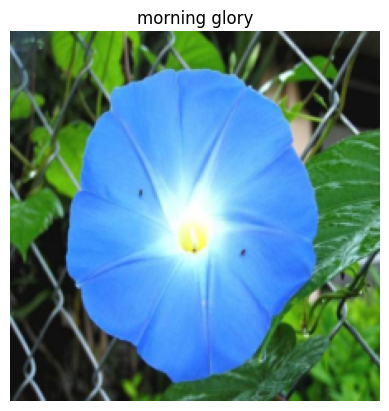

In [ ]:
images, labels = next(iter(train_dataloader))

# Just take first image to show
image, label = images[0], labels[0]

# Plot using pyplot

import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # color channels from start to end
plt.title(class_names[label])
plt.axis(False)
plt.show()

Verifying the input and output shape for the embedding layer

In [ ]:
height, width, channels = 224, 224, 3

patch_size = 16  # Each patch is a 16 x 16 part of the original image

image_shape = (height, width, channels)
print(f"Image Shape: {image_shape}")

number_of_patches = height * width // patch_size**2  # Just turns all into pixels and gets the patch size by dividing

print(f"Number of Patches: {number_of_patches}")

Image Shape: (224, 224, 3)
Number of Patches: 196


Now to calculate the input shape of the patches which will be sent inside

In [ ]:
patch_inputs = (number_of_patches, patch_size**2 * channels)  # Basically just flattened each patch separately and put in the input tensor

print(f"Embedding shape: {patch_inputs}")

Embedding shape: (196, 768)


##Actually creating the patches

torch.Size([3, 224, 224])


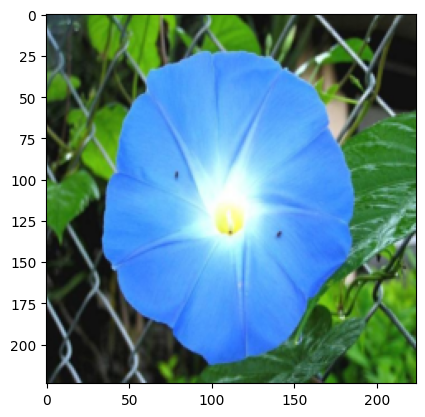

In [ ]:
# Permute to fit pyplot

print(image.shape)
image_permuted = image.permute(1,2,0)

plt.imshow(image_permuted)

###Plot just a single row

---



(-0.5, 223.5, 15.5, -0.5)

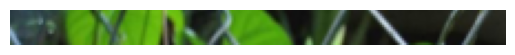

In [ ]:
plt.imshow(image_permuted[:patch_size, :, :])
plt.axis(False)

###Take this single row and cut into multiple columns according to the patches

In [ ]:
img_size = 224  # For more readability
assert img_size % patch_size == 0  # Cleanly division with patch_size only
num_patches = img_size // patch_size

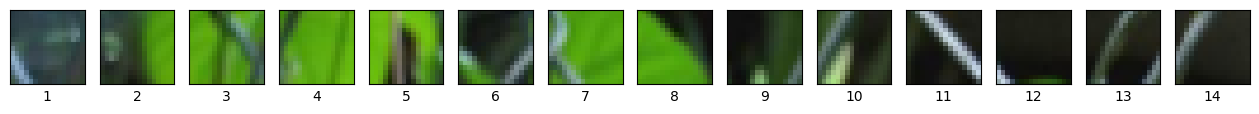

In [ ]:
fig, axs = plt.subplots(
    nrows = 1,
    ncols = num_patches,
    sharex = True,
    sharey = True,
    figsize = (patch_size, patch_size)
)

for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch + patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

###Plotting patches of entire image

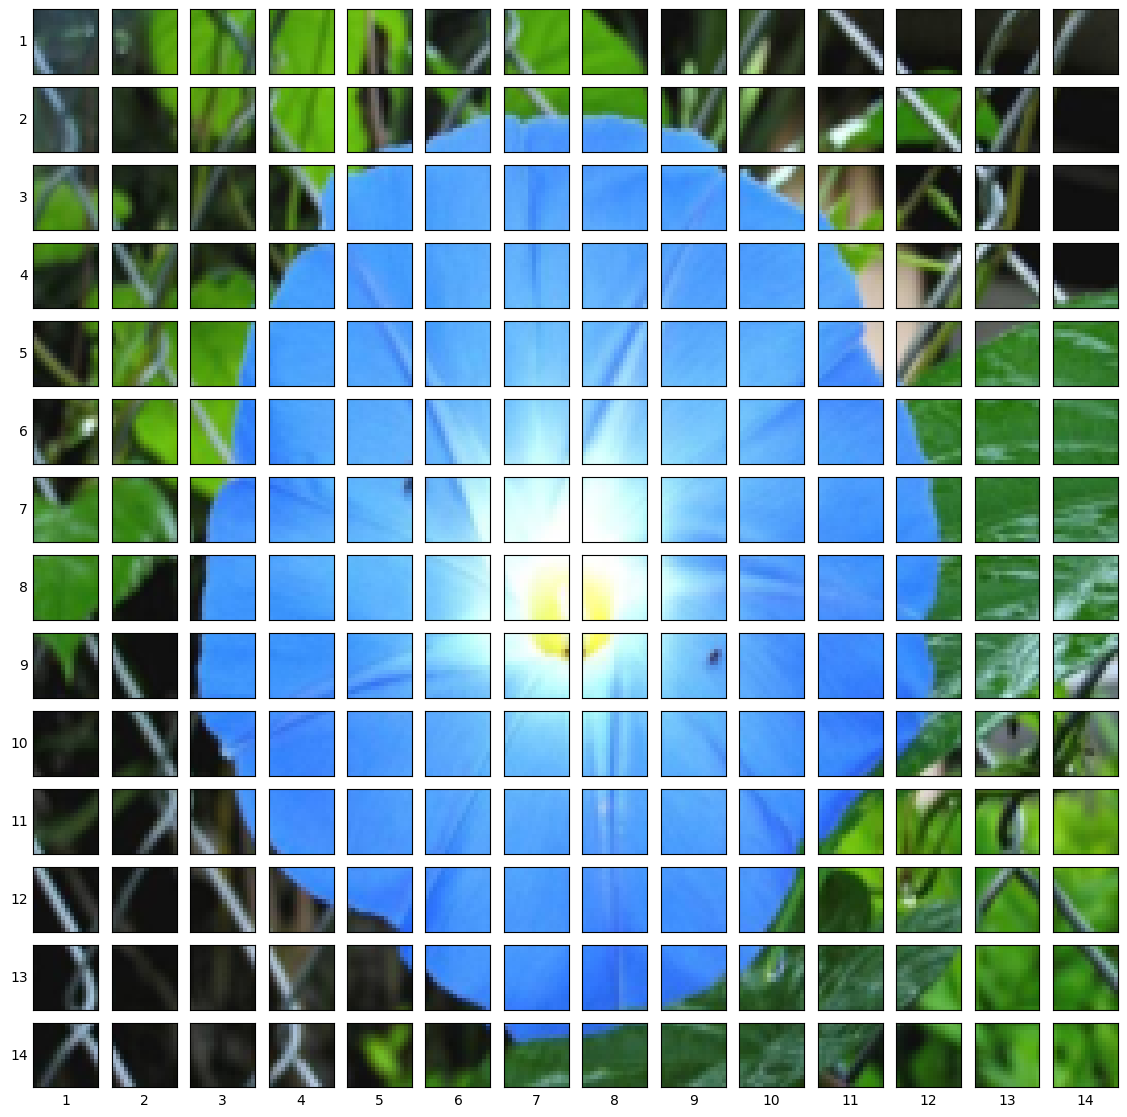

In [ ]:
fig, axs = plt.subplots(
    nrows = num_patches,
    ncols = num_patches,
    sharex = True,
    sharey = True,
    figsize = (num_patches, num_patches)
)

for i, row_patch in enumerate(range(0, img_size, patch_size)):
  for j, col_patch in enumerate(range(0, img_size, patch_size)):
    axs[i,j].imshow(image_permuted[row_patch:row_patch+patch_size, col_patch:col_patch+patch_size, :])
    axs[i,j].set_ylabel(i + 1, rotation = "horizontal", horizontalalignment = "right", verticalalignment = "center")
    axs[i,j].set_xlabel(j + 1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()

##Creating embeddings using Conv2D for both speed and learnability of embeddings

In [ ]:
import torch
from torch import nn

conv2d_embedder = nn.Conv2d(
    in_channels = 3,
    out_channels = 768,
    kernel_size = patch_size,
    stride = patch_size,
    padding = 0
)

conv2d_embedder

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [ ]:
embedder_output = conv2d_embedder(image)

In [ ]:
embedder_output.shape

torch.Size([768, 14, 14])

###Flattening to get all the patches in a line

In [ ]:
flatten = nn.Flatten(
    start_dim = -2,
    end_dim = -1
)

flatten(embedder_output).shape

torch.Size([768, 196])

In [ ]:
# Rearrange in the needed order
flatten(embedder_output).permute(1,0).shape

torch.Size([196, 768])

###Putting it all together

In [ ]:
embedder = nn.Sequential(
    nn.Conv2d(3, 768, 16, 16, 0),
    nn.Flatten(-2, -1)
)

embedder(image).permute(1,0).shape

torch.Size([196, 768])

###Creating the PatchEmbedding Module

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, patch_size: int = 16, channels: int = 3, embedding_size: int = 768):
    super().__init__()
    self.patch_size = patch_size  # somehow patch_size and channels were visible without setting them up as a self variable but embedding_size was not
    # Solved the above problem and it has to do with whether a variable or literal was passed to the constructor
    self.embedding_layer = nn.Sequential(nn.Conv2d(channels, embedding_size, patch_size, patch_size, 0),
                                         nn.Flatten(-2, -1))

  def forward(self, x: torch.Tensor):
    assert x.shape[-1] % self.patch_size == 0, f"Image size must be divisible by patch size. Got input shape: {x.shape}, patch size: {self.patch_size}"
    return self.embedding_layer(x).permute(0, 2, 1)

embedding_size = 768
patch_embedding = PatchEmbedding(patch_size, channels, embedding_size)

patch_embedded_image = patch_embedding(image.unsqueeze(0))
patch_embedded_image.shape

torch.Size([1, 196, 768])

###Adding a learnable class embedding to the patch_embedding

In [ ]:
print(f"patch embedded image shape: {patch_embedded_image.shape}")

# Add a sequence of ones to make the dimension (1, 197, 768) for visibility. In practice, will add randn
batch_size = patch_embedded_image.shape[0]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_size))
print(f"class token shape: {class_token.shape}")

# Adding them to the patch embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedded_image), 1)  # torch.cat checks whether the dimensions of all tensors in the patch_embedding match
                                                                                      # in the dimensions other than `dim` and adds them in sequential order
print(f"patch embedding with class token shape: {patch_embedding_with_class_token.shape}")
patch_embedding_with_class_token

patch embedded image shape: torch.Size([1, 196, 768])
class token shape: torch.Size([1, 1, 768])
patch embedding with class token shape: torch.Size([1, 197, 768])


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.0963, -0.2516, -0.2779,  ..., -0.0919, -0.0375,  0.4367],
         [ 0.0881, -0.3090, -0.0977,  ..., -0.0483, -0.0560,  0.2968],
         ...,
         [ 0.0972, -0.0546, -0.0596,  ..., -0.0367, -0.1419,  0.3215],
         [ 0.1228, -0.1564, -0.1978,  ..., -0.0226, -0.0049,  0.3752],
         [ 0.1044, -0.2043, -0.2252,  ..., -0.1653, -0.0334,  0.4868]]],
       grad_fn=<CatBackward0>)

###Adding the position embeddings

In [ ]:
position_embedding = nn.Parameter(torch.ones(batch_size, patch_embedding_with_class_token.shape[1], embedding_size))
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
patch_and_position_embedding = patch_embedding_with_class_token + position_embedding
patch_and_position_embedding, patch_and_position_embedding.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [1.0963, 0.7484, 0.7221,  ..., 0.9081, 0.9625, 1.4367],
          [1.0881, 0.6910, 0.9023,  ..., 0.9517, 0.9440, 1.2968],
          ...,
          [1.0972, 0.9454, 0.9404,  ..., 0.9633, 0.8581, 1.3215],
          [1.1228, 0.8436, 0.8022,  ..., 0.9774, 0.9951, 1.3752],
          [1.1044, 0.7957, 0.7748,  ..., 0.8347, 0.9666, 1.4868]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

###Putting it all together

1. Create Patch embeddings through conv2d, flatten and then permute
2. Add Class token to the start of patch embedding
3. Add position embedding to create final embedding

In [ ]:
print(f"Image shape: {image.shape}")

# Patch embedding
patch_embedding = PatchEmbedding(patch_size, channels, embedding_size)
patch_embedded_image = patch_embedding(image.unsqueeze(0))

print(f"Patch embedded Image shape: {patch_embedded_image.shape}")

# Class Token
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_size))
patch_embedding_with_class_token = torch.cat((class_token, patch_embedded_image), dim = 1)
print(f"Shape with class token: {patch_embedding_with_class_token.shape}")

# Position Embedding
position_embedding = nn.Parameter(torch.ones(patch_embedding_with_class_token.shape))
print(position_embedding, position_embedding.shape)
patch_class_and_position_embedding = patch_embedding_with_class_token + position_embedding
print(f"Patch with class and postion embedding shape: {patch_class_and_position_embedding.shape}")
print(patch_class_and_position_embedding)

Image shape: torch.Size([3, 224, 224])
Patch embedded Image shape: torch.Size([1, 196, 768])
Shape with class token: torch.Size([1, 197, 768])
Parameter containing:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True) torch.Size([1, 197, 768])
Patch with class and postion embedding shape: torch.Size([1, 197, 768])
tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.0252, 1.0495, 0.8677,  ..., 0.9827, 0.9784, 0.9889],
         [0.9268, 1.0233, 0.8749,  ..., 0.8064, 0.8358, 0.9428],
         ...,
         [0.8999, 0.9448, 0.8981,  ..., 0.9538, 0.9587, 0.9696],
         [0.9148, 0.9103, 0.8181,  ..., 0.8627, 0.7015, 0.9389],
         [0.9582, 0.9785, 0.8409,  ..., 0.7690, 0.7748, 0.9999]]],
       grad_fn=<AddBackward0>)


###Putting everything in the `PatchEmbedding` class

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               num_patches: int = 196,
               patch_size: int = 16,
               channels: int = 3,
               embedding_size: int = 768,
               embedding_dropout: float = 0.1):
    super().__init__()
    self.patch_size = patch_size
    self.num_patches = num_patches

    self.patcher = nn.Sequential(nn.Conv2d(channels, embedding_size, patch_size, patch_size, 0),
                                 nn.Flatten(-2, -1))

    self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_size))

    self.position_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embedding_size))

    self.embedding_dropout_layer = nn.Dropout(embedding_dropout)

  def forward(self, x: torch.Tensor):
    batch_size = x.shape[0]
    assert x.shape[-1] % self.patch_size == 0, f"Image size must be divisible by patch size. Got input shape: {x.shape}, patch size: {self.patch_size}"
    x = self.patcher(x).permute(0, 2, 1)

    self.class_embedding_batch = self.class_embedding.expand(batch_size, -1, -1)
    x = torch.cat((self.class_embedding_batch, x), dim = 1)

    self.position_embedding_batch = self.position_embedding.expand(batch_size, -1, -1)
    x = x + self.position_embedding_batch

    x = self.embedding_dropout_layer(x)
    return x


patch_embedding = PatchEmbedding()
single_embedded_image = patch_embedding(image.unsqueeze(0))

# Full Batch
test_images = images[:5]
test_images.shape

final_embedded_images = patch_embedding(test_images)

print(f"Single Embedding Shape: {single_embedded_image.shape}")
print(f"Multiple Embedding Shape: {final_embedded_images.shape}")

Single Embedding Shape: torch.Size([1, 197, 768])
Multiple Embedding Shape: torch.Size([5, 197, 768])


##Multi-head Self Attention (MSA Block)

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_size: int = 768,
               num_heads: int = 12,
               num_patches: int = 196):
    super().__init__()
    self.layernorm = nn.LayerNorm(embedding_size)
    self.msa = nn.MultiheadAttention(embedding_size, num_heads, batch_first = True)

  def forward(self, x: torch.Tensor):
    z = self.layernorm(x)
    attention_output, _ = self.msa(z, z, z)
    return attention_output + x

msa_block = MultiHeadSelfAttentionBlock()
msa_output = msa_block(single_embedded_image)
msa_output.shape

torch.Size([1, 197, 768])

##MLP Block

In [ ]:
class MultiLayerPerceptronBlock(nn.Module):
  def __init__(self,
               embedding_size: int = 768,
               hidden_units: int = 3072,
               dropout: float = 0.1):
    super().__init__()
    self.layernorm = nn.LayerNorm(embedding_size)
    self.mlp = nn.Sequential(
        nn.Linear(embedding_size, hidden_units),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_units, embedding_size),
        nn.Dropout(dropout)
    )

  def forward(self, x: torch.Tensor):
    return self.mlp(self.layernorm(x)) + x

mlp_block = MultiLayerPerceptronBlock()
mlp_output = mlp_block(msa_output)
mlp_output.shape

torch.Size([1, 197, 768])

##Transformer Encoder Class

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self,
               embedding_size: int = 768,
               num_patches: int = 196,
               num_heads: int = 12,
               hidden_units: int = 3072,
               dropout: float = 0.1):
    super().__init__()

    self.msa_block = MultiHeadSelfAttentionBlock(
        embedding_size = embedding_size,
        num_heads = num_heads,
        num_patches = num_patches
    )

    self.mlp_block = MultiLayerPerceptronBlock(
        embedding_size = embedding_size,
        hidden_units = hidden_units,
        dropout = dropout
    )

  def forward(self, x: torch.Tensor):
    return self.mlp_block(self.msa_block(x))

transformer_encoder = TransformerEncoder()
transformer_encoder_output = transformer_encoder(final_embedded_images)
transformer_encoder_output.shape

torch.Size([5, 197, 768])

###Summary of the Encoder Block

In [ ]:
summary(model = transformer_encoder,
        input_size = (1, 197, 768),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)     [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)                  [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (msa)               [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─MultiLayerPerceptronBlock (mlp_block)       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)                  [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                       [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                        [1, 197, 768]        [1, 197, 3072]  

Using Built-in PyTorch TransformerEncoder Layer

In [ ]:
torch_transformer_encoder = nn.TransformerEncoderLayer(
    d_model = embedding_size,
    nhead = 12,
    dim_feedforward = 3072,
    dropout = 0.1,
    activation = "gelu",
    norm_first = True,
    batch_first = True
)

summary(model = torch_transformer_encoder,
        input_size = (1, 197, 768),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

##Creating the complete ViT

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self,
               num_patches: int = 196,
               patch_size: int = 16,
               channels: int = 3,
               embedding_size: int = 768,
               num_heads: int = 12,
               hidden_units: int = 3072,
               dropout: float = 0.1,
               num_encoders: int = 12,
               num_classes:int = 1000):
    super().__init__()

    self.num_encoders = num_encoders

    self.patch_embedding_layer = PatchEmbedding(
        num_patches = num_patches,
        patch_size = patch_size,
        channels = channels,
        embedding_size = embedding_size
    )

    self.transformer_encoder = nn.Sequential(*[
        TransformerEncoder(
          embedding_size = embedding_size,
          num_patches = num_patches,
          num_heads = num_heads,
          hidden_units = hidden_units,
          dropout = dropout
      )
      for _ in range(num_encoders)
    ])

    self.classifier = nn.Sequential(
        nn.LayerNorm(embedding_size),
        nn.Linear(in_features = embedding_size,
                  out_features = num_classes)
    )

  def forward(self, x: torch.Tensor):
    x = self.patch_embedding_layer(x)
    x = self.transformer_encoder(x)
    x = self.classifier(x[:, 0, :])
    return x

vision_transformer = VisionTransformer(num_classes = len(class_names))
single_complete_output = vision_transformer(image.unsqueeze(0))
print(f"Single Image output: {single_complete_output.shape}")

multiple_complete_output = vision_transformer(test_images)
print(f"Multiple Images output: {multiple_complete_output.shape}")

Single Image output: torch.Size([1, 102])
Multiple Images output: torch.Size([5, 102])


In [ ]:
summary(model = vision_transformer,
        input_size = (1, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                   [1, 3, 224, 224]     [1, 102]             --                   True
├─PatchEmbedding (patch_embedding_layer)                [1, 3, 224, 224]     [1, 197, 768]        152,064              True
│    └─Sequential (patcher)                             [1, 3, 224, 224]     [1, 768, 196]        --                   True
│    │    └─Conv2d (0)                                  [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    │    └─Flatten (1)                                 [1, 768, 14, 14]     [1, 768, 196]        --                   --
│    └─Dropout (embedding_dropout_layer)                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    └─

##Training Setup

In [ ]:
from going_modular.going_modular import engine

set_seeds()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = vision_transformer.parameters(),
                             lr = 1e-3,
                             weight_decay = 0.1)

epochs = 10
results = engine.train(vision_transformer,
                       train_dataloader,
                       test_dataloader,
                       optimizer,
                       loss_fn,
                       epochs,
                       device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1320 | train_acc: 0.0088 | test_loss: 4.6867 | test_acc: 0.0100
Epoch: 2 | train_loss: 4.8289 | train_acc: 0.0039 | test_loss: 4.7883 | test_acc: 0.0089
Epoch: 3 | train_loss: 4.8384 | train_acc: 0.0020 | test_loss: 4.7000 | test_acc: 0.0032
Epoch: 4 | train_loss: 4.8464 | train_acc: 0.0039 | test_loss: 4.7952 | test_acc: 0.0032
Epoch: 5 | train_loss: 4.8288 | train_acc: 0.0049 | test_loss: 4.8346 | test_acc: 0.0042
Epoch: 6 | train_loss: 4.8157 | train_acc: 0.0049 | test_loss: 4.7152 | test_acc: 0.0105
Epoch: 7 | train_loss: 4.8134 | train_acc: 0.0049 | test_loss: 4.6960 | test_acc: 0.0065
Epoch: 8 | train_loss: 4.8198 | train_acc: 0.0078 | test_loss: 4.7026 | test_acc: 0.0118
Epoch: 9 | train_loss: 4.7757 | train_acc: 0.0059 | test_loss: 4.6325 | test_acc: 0.0142
Epoch: 10 | train_loss: 4.7863 | train_acc: 0.0029 | test_loss: 4.6973 | test_acc: 0.0076


###Plotting the curves

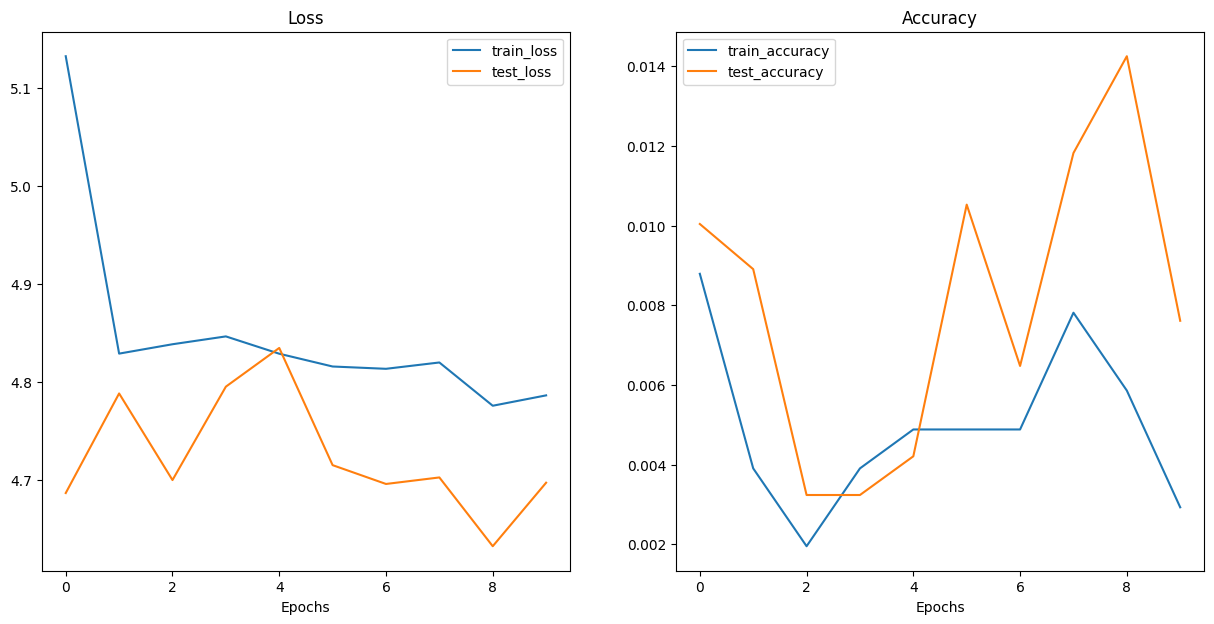

In [ ]:
plot_loss_curves(results)

There is not enough data to properly fit so many parameters

##Transfer Learning

In [ ]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"

vit_b_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_b_pretrained = torchvision.models.vit_b_16(weights = vit_b_weights)

vit_b_pretrained

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 173MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Freezing all layers

In [ ]:
for param in vit_b_pretrained.parameters():
  param.requires_grad = False

summary(model = vit_b_pretrained,
        input_size = (1, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  False
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197

Now, overwriting last heads layers with a new one with `out_features = len(class_names)`

In [ ]:
vit_b_pretrained.heads = nn.Linear(in_features = embedding_size,
                                   out_features = len(class_names))
vit_b_pretrained

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
summary(model = vit_b_pretrained,
        input_size = (1, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 102]             768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

###Setup the transforms for the pretrained vit model

In [ ]:
vit_transforms = vit_b_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Creating new dataloaders with these transforms

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.Flowers102(
    root = "data",
    split = "train",
    download = True,
    transform = vit_transforms,
    target_transform = None
)

test_data = datasets.Flowers102(
    root = "data",
    split = "test",
    download = True,
    transform = vit_transforms,
    target_transform = None
)

from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader_pretrained = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_dataloader_pretrained = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    shuffle = False
)

###Fine Tuning with our data

In [ ]:
vit_b_pretrained = vit_b_pretrained.to(device)

In [ ]:
set_seeds()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = vit_b_pretrained.parameters(),
                             lr = 1e-3,
                             weight_decay = 0.1)

epochs = 10
results = engine.train(vit_b_pretrained,
                       train_dataloader_pretrained,
                       test_dataloader_pretrained,
                       optimizer,
                       loss_fn,
                       epochs,
                       device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.2895 | train_acc: 0.1281 | test_loss: 3.6858 | test_acc: 0.4123
Epoch: 2 | train_loss: 3.1538 | train_acc: 0.6322 | test_loss: 3.0034 | test_acc: 0.6394
Epoch: 3 | train_loss: 2.4569 | train_acc: 0.8255 | test_loss: 2.6272 | test_acc: 0.6989
Epoch: 4 | train_loss: 2.0345 | train_acc: 0.8856 | test_loss: 2.3664 | test_acc: 0.7570
Epoch: 5 | train_loss: 1.7943 | train_acc: 0.9303 | test_loss: 2.2392 | test_acc: 0.7674
Epoch: 6 | train_loss: 1.6587 | train_acc: 0.9314 | test_loss: 2.1603 | test_acc: 0.7695
Epoch: 7 | train_loss: 1.5842 | train_acc: 0.9489 | test_loss: 2.1078 | test_acc: 0.7905
Epoch: 8 | train_loss: 1.5325 | train_acc: 0.9530 | test_loss: 2.0785 | test_acc: 0.7848
Epoch: 9 | train_loss: 1.4928 | train_acc: 0.9538 | test_loss: 2.0576 | test_acc: 0.7977
Epoch: 10 | train_loss: 1.4671 | train_acc: 0.9618 | test_loss: 2.0321 | test_acc: 0.7987


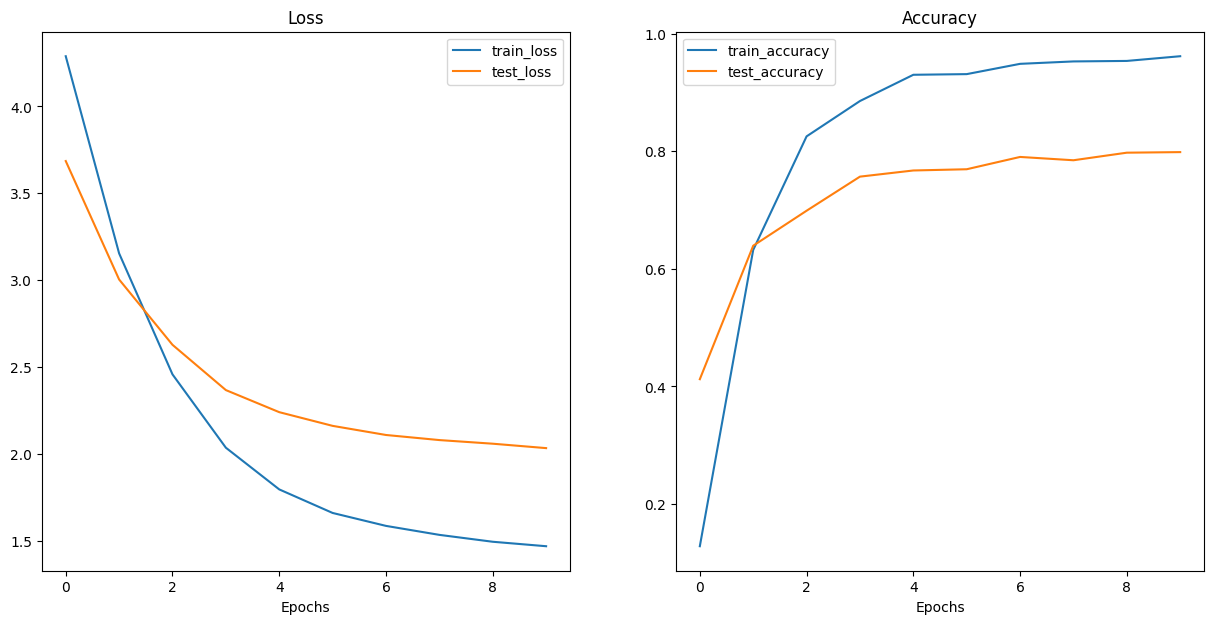

In [ ]:
plot_loss_curves(results)

Much better results

###Saving the model

In [ ]:
from going_modular.going_modular import utils

utils.save_model(model = vit_b_pretrained,
                 target_dir = "models",
                 model_name = "vit_b_16_food_vision_mini.pth")

[INFO] Saving model to: models/vit_b_16_food_vision_mini.pth


In [ ]:
!du -h models

328M	models
